In [ ]:
!pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 kB 14.4 MB/s eta 0:00:00


In [2]:
import os
# os.chdir("/content/drive/MyDrive/Datasets")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sktime.forecasting.compose import make_reduction
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.utils.plotting import plot_series

In [29]:
df = pd.read_csv("monthly-milk-production-pounds-p.csv",index_col=0)
idx = pd.to_datetime( df.index ).to_period("M")
df.index = idx
df

,Milk
Month,
1962-01,589
1962-02,561
1962-03,640
1962-04,656
1962-05,727
...,...
1975-08,858
1975-09,817
1975-10,827


In [4]:
y_train, y_test = temporal_train_test_split(df,test_size=12)

In [5]:
y_train.shape

(156, 1)

In [6]:
y_test.shape

(12, 1)

In [7]:
fh = np.arange(1, len(y_test) + 1)  # forecasting horizon
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [8]:
regressor = RandomForestRegressor(random_state=23)

In [9]:
forecaster = make_reduction(regressor,window_length=7)
forecaster

RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(random_state=23),
                                     window_length=7)

In [10]:
forecaster.fit(y_train)

RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(random_state=23),
                                     window_length=7)

In [11]:
y_pred = forecaster.predict(fh)
rmse = MeanSquaredError(square_root=True)
print(rmse(y_test, y_pred))

80.39071339402332


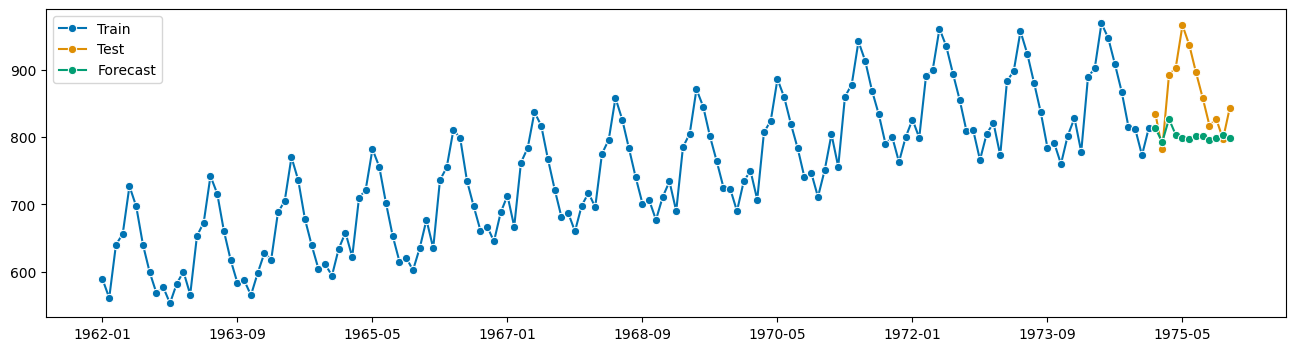

In [12]:
plot_series(y_train,y_test,y_pred , labels=['Train','Test','Forecast'])
plt.show()

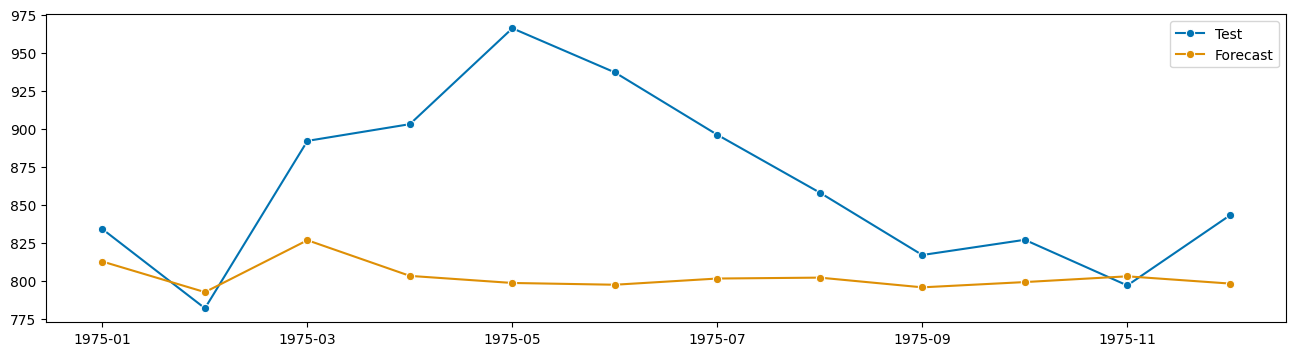

In [13]:
plot_series(y_test,y_pred , labels=['Test','Forecast'])
plt.show()

**Basic Grid Search**

In [14]:
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import ForecastingGridSearchCV, SlidingWindowSplitter

In [15]:
forecaster = make_reduction(regressor, window_length=15, strategy="recursive")
param_grid = {"window_length": [7, 12, 15]}

We fit the forecaster on an initial window which is 80% of the historical data
then use temporal sliding window cross-validation to find the optimal hyper-parameters


In [16]:
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=20)
gscv = ForecastingGridSearchCV(
    forecaster, strategy="refit", cv=cv, param_grid=param_grid
)

In [17]:
gscv.fit(y_train)

C:\Users\dbda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sktime\forecasting\model_selection\_tune.py:198: UserWarning: in ForecastingGridSearchCV, n_jobs and pre_dispatch parameters are deprecated and will be removed in 0.26.0. Please use n_jobs and pre_dispatch directly in the backend_params argument instead.
  warn(


ForecastingGridSearchCV(cv=SlidingWindowSplitter(initial_window=124,
                                                 window_length=20),
                        forecaster=RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(random_state=23),
                                                                        window_length=15),
                        param_grid={'window_length': [7, 12, 15]})

In [18]:
print(gscv.best_params_)

{'window_length': 7}


In [19]:
print(gscv.best_score_)

0.02683423009024043


(<Figure size 1600x400 with 1 Axes>, <Axes: >)

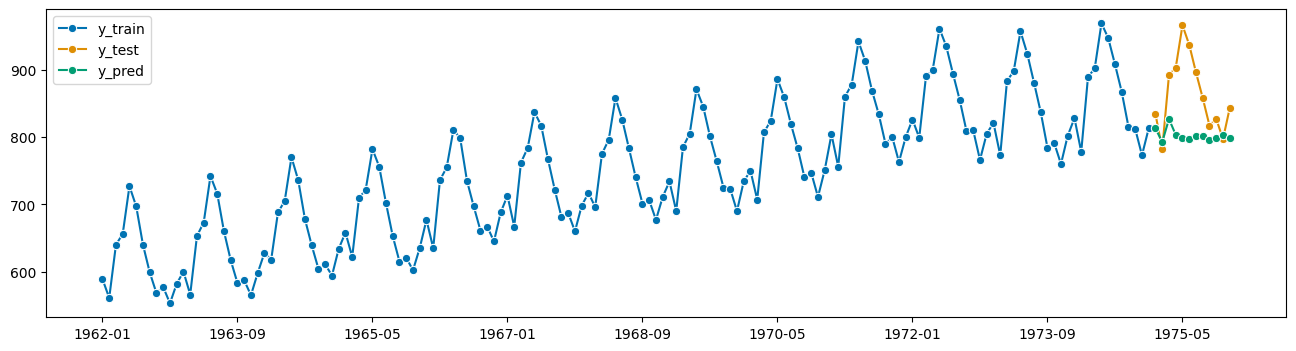

In [20]:
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [21]:
print(rmse(y_test, y_pred))

80.39071339402332


**Composite Grid Search**

In [22]:
forecaster = make_reduction(regressor, window_length=15, strategy="recursive")
param_grid = {"window_length": [6,7,8,9,10],
              'estimator__max_features':[2,3,4,5]}
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=20)
gscv = ForecastingGridSearchCV(forecaster, strategy="refit", cv=cv, param_grid=param_grid)

In [23]:
gscv.fit(y_train)

C:\Users\dbda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sktime\forecasting\model_selection\_tune.py:198: UserWarning: in ForecastingGridSearchCV, n_jobs and pre_dispatch parameters are deprecated and will be removed in 0.26.0. Please use n_jobs and pre_dispatch directly in the backend_params argument instead.
  warn(


ForecastingGridSearchCV(cv=SlidingWindowSplitter(initial_window=124,
                                                 window_length=20),
                        forecaster=RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(random_state=23),
                                                                        window_length=15),
                        param_grid={'estimator__max_features': [2, 3, 4, 5],
                                    'window_length': [6, 7, 8, 9, 10]})

In [24]:
print(gscv.best_params_)

{'estimator__max_features': 4, 'window_length': 8}


In [25]:
print(gscv.best_score_)

0.026995248420505984


(<Figure size 1600x400 with 1 Axes>, <Axes: >)

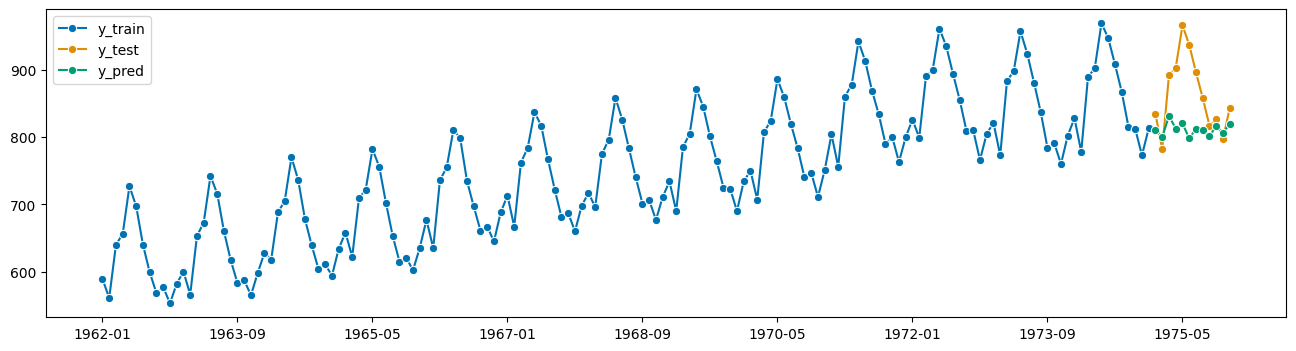

In [26]:
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [27]:
print(rmse(y_test, y_pred))

72.78174942937275


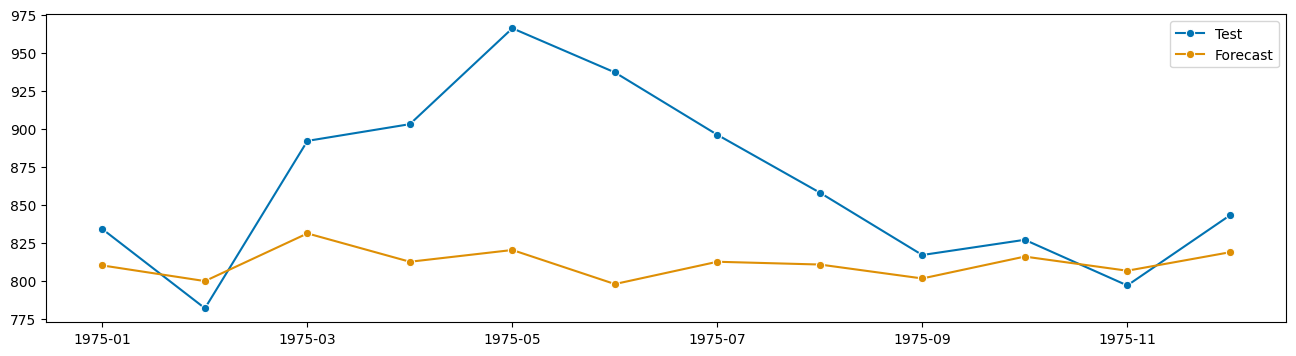

In [28]:
plot_series(y_test,y_pred , labels=['Test','Forecast'])
plt.show()